# 朴素贝叶斯算法原理与搜狗新闻分类实战

## 贝叶斯公式
贝叶斯公式就一行：

$$P(Y|X)=P(X|Y)P(Y)P(X)$$
而它其实是由以下的联合概率公式推导出来：

$$P(Y,X)=P(Y|X)P(X)=P(X|Y)P(Y)$$
其中$P(Y)$叫做先验概率， $P(Y|X)$叫做后验概率，$P(Y,X)$叫做联合概率。

没了，贝叶斯最核心的公式就这么些。

## 机器学习的视角理解贝叶斯公式
在机器学习的视角下，我们把 X 理解成“具有某特征”，把 Y 理解成“类别标签”(一般机器学习为题中都是X=>特征, Y=>结果对吧)。在最简单的二分类问题(是与否判定)下，我们将 Y 理解成“属于某类”的标签。于是贝叶斯公式就变形成了下面的样子:

$$P(“属于某类”|“具有某特征”)=P(“具有某特征”|“属于某类”)P(“属于某类”)P(“具有某特征”)$$ 
我们简化解释一下上述公式：

- $P(“属于某类”|“具有某特征”)=$在已知某样本“具有某特征”的条件下，该样本“属于某类”的概率。所以叫做『后验概率』。
- $P(“具有某特征”|“属于某类”)$= 在已知某样本“属于某类”的条件下，该样本“具有某特征”的概率。 
- $P(“属于某类”)$= （在未知某样本具有该“具有某特征”的条件下，）该样本“属于某类”的概率。所以叫做『先验概率』。
- $P(“具有某特征”)$= (在未知某样本“属于某类”的条件下，)该样本“具有某特征”的概率。

而我们二分类问题的最终目的就是要判断$P(“属于某类”|“具有某特征”)$是否大于1/2就够了。贝叶斯方法把计算**"具有某特征的条件下属于某类"**的概率转换成需要计算“属于某类的条件下具有某特征”的概率，而后者获取方法就简单多了，我们只需要找到一些包含已知特征标签的样本，即可进行训练。而样本的类别标签都是明确的，所以贝叶斯方法在机器学习里属于有监督学习方法。

这里再补充一下，一般『先验概率』、『后验概率』是相对出现的，比如 P(Y) 与 P(Y|X) 是关于 Y 的先验概率与后验概率， P(X) 与 P(X|Y) 是关于 X 的先验概率与后验概率。

## 搜狗新闻主题分类
- 这是一个文本分类问题，经典的新闻主题分类，下面用朴素贝叶斯来做

In [1]:
import os
import time
import random
import jieba  # 处理中文
import nltk   # 处理英文
import sklearn
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def text_processing(folder_path, test_rate=0.2):
    data_list = []
    label_list = []

    folder_list = os.listdir(folder_path)
    for folder in folder_list:
        text_folder_path = os.path.join(folder_path, folder)
        text_files = os.listdir(text_folder_path)

        # 读取每个文件
        n = 1
        for file in text_files:
            if n > 100:
                # 怕内存爆掉，只取100个样本文件，后期可以注释掉
                print("n>100")
                break
            with open(os.path.join(text_folder_path, file), "r") as f:
                text = f.read()
                # read() 返回值为str，每次读取整个文件，将文件所有内容放到一个字符串变量中
                # readline() 返回值为str，每次只读取一行,每行的内容放在一个字符串变量中
                # readlines() 返回值为list，一次读取整个文件，每行的内容放在一个字符串变量中作为列表的一个元素。

            # 使用jieba分词
            # 开启并行分词,参数为并行进程数
            jieba.enable_parallel()
            word_cut = jieba.cut(text, cut_all=False) # 精确模式，返回的结构是一个可迭代的genertor
            word_list = list(word_cut)
            jieba.disable_parallel() # 关闭并行分词模式

            data_list.append(word_list) # 训练集list
            label_list.append(folder)  # 训练集标签分类
            n += 1

    # 划分数据集和测试集
    data_label_list = list(zip(data_list, label_list))
    random.shuffle(data_label_list)

    idx = int(len(data_label_list)*test_rate)+1
    print("总样本数：", len(data_label_list))
    train_list = data_label_list[idx:]
    test_list = data_label_list[:idx]
    # print(train_list)
    
    # 这里返回包含一组列表的元祖（[]）
    train_data_li, train_label_li = zip(*train_list)
    test_data_li, test_label_li = zip(*test_list)

    # 统计词频，得到词频逆序字典?为什么不用总的样本来统计词频而是用训练集
    vocab_dict = dict(Counter([w for li in train_data_li for w in li]))
    vocab_list = sorted(vocab_dict.items(), key=lambda f: f[1], reverse=True)

    vocab_list, _ = zip(*vocab_list)
    vocab_list = list(vocab_list)
    return vocab_list, train_data_li, train_label_li, test_data_li, test_label_li

In [4]:
random.seed(2019)
folder_path = "Database/SogouC/Sample"
vocab_list, train_data_list, train_label_list, test_data_list, test_label_list = text_processing(folder_path, test_rate=0.2)
print("词汇个数：", len(vocab_list))   
print("训练集样本个数：", len(train_data_list)) 
print("测试集样本个数：", len(test_data_list)) 
print("训练集标签：", len(train_label_list)) 
print("测试集标签：", len(test_label_list)) 

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.009 seconds.
Prefix dict has been built succesfully.


总样本数： 90
词汇个数： 9875
训练集样本个数： 71
测试集样本个数： 19
训练集标签： 71
测试集标签： 19


## 停用词去重
- 清洗停用词

In [6]:
# 词去重
def make_word_set(words_file):
    words_set = set()
    with open(words_file, "r") as f:
        for line in f:
            word = line.strip()
            if len(word) > 0 and word not in words_set:
                words_set.add(word)
    return words_set

In [7]:
stopwords_file = "./stopwords_cn.txt"
stopwords_set = make_word_set(stopwords_file)  # 去重后的停用词
print("停用词个数：", len(stopwords_set))
print("stopwords_set:", stopwords_set)

停用词个数： 428
stopwords_set: {'甚至于', '仍旧', '并不', '此次', '全体', '所', '依照', '沿着', '嘛', '否则', '才是', '何处', '万一', '可以', '曾', '但', '且', '您', '那样', '嗡', '或是', '下', '鉴于', '而外', '还是', '另外', '吧', '既然', '说来', '尔', '当地', '这会', '被', '他们', '然而', '本地', '那时', '甚至', '一', '或者说', '或', '受到', '别处', '了', '哟', '诸', '不论', '哪些', '其余', '凡', '只消', '上', '彼此', '哪', '这', '即', '何况', '进而', '果然', '由于', '不尽', '因而', '不单', '距', '之', '多会', '与', '及至', '就是说', '则', '与否', '这里', '例如', '此外', '多么', '朝着', '只有', '简言之', '来自', '这么', '随', '由此', '这边', '后者', '所在', '往', '哪怕', '此处', '既往', '唯有', '不只', '仍', '比如', '以来', '许多', '致', '就是', '是', '若是', '去', '又及', '趁', '又', '同', '除外', '个人', '至今', '宁可', '它们', '由', '使', '得', '在于', '此', '向着', '我', '而已', '个', '全部', '如上', '不然', '比', '两者', '跟', '另', '你', '个别', '自己', '为了', '此间', '那儿', '介于', '诸位', '无', '就算', '一切', '嘻嘻', '有的', '对比', '接着', '倘若', '呵呵', '一些', '只', '一旦', '儿', '前者', '那些', '本着', '譬如', '只限于', '再有', '啦', '而是', '出来', '除非', '怎么办', '所有', '连带', '别的', '不仅', '何以', '自从', '或者', '从', '某些', '当然', '虽然', '正巧', '即

## 从词袋中选取有代表的特征词
- 第一步生成的词袋里有很多通用的、无意义的词语，需要去掉。  
- 有代表性的词语很大概率是一些对最终类别区分有作用的词语。并且后面这些词语会作为特征作为模型的输入。

In [9]:
def vocab_select(vocab_list, deleteN, stopwords_set=set()):
    # 选取特征词
    feature_words = []
    n = 1
    # 从deleteN 开始，舍弃前从deleteN个单词
    # 因为越前面的词词频越高，在所有类别中都可能出现很多次
    for t in range(deleteN, len(vocab_list), 1):
        if n > 1000:
            # 选取1000个词汇，也就是特征词是1000
            break
        # 满足三个条件：不是数字；不在停用词表；长度2～4就添加到特征词列表
        if not vocab_list[t].isdigit() and \
            vocab_list[t] not in stopwords_set and \
            1<len(vocab_list[t])<5:
                feature_words.append(vocab_list[t])
                n += 1
    return feature_words

In [10]:
deleteN = 20 
# 删除前词频高的top20个词语,可以调整这个数值
feature_words = vocab_select(vocab_list, deleteN, stopwords_set)
print(feature_words[:100])

['公司', '一个', '游客', '旅游', '导弹', '考生', '大陆', '认为', '火炮', '台军', '进行', '时间', '一种', '解放军', '各种', '美国', '没有', '北京', '市场', '作战', '支付', '志愿', '成为', '已经', '仿制', '发展', '复习', '远程', '工作', '很多', '建设', '主要', '可能', '目前', '通过', '企业', '五一', '问题', '品牌', '学习', '黄金周', '射程', '银行', '技术', '一定', '部分', '基础', '增长', '部署', '分析', '上海', '亿美元', '学校', '考试', '词汇', '选择', '辅导班', '期间', '完全', '能力', '记者', '文章', '时候', '表示', '训练', '专业', '毕业生', '部队', '需要', '重要', '专家', '收入', '提高', '填报', '今年', '军事', '阵地', '计划', '必须', '达到', '坦克', '影响', '用户', '电话', '管理', '科学', '开始', '拥有', '表现', '资料', '万人次', '几乎', '来源', '发现', '相关', '准备', '服务', '提供', '要求', '销售']


## 训练和测试集生成固定长度的词向量特征
- 这步为后面数据输入进贝叶斯模型训练做准备。
- 因为文本长度不一，所以每个样本需要固定好维度，才能喂给模型训练。
- nltk 与sklearn中的训练数据类型不一样，应该分别处理

In [12]:
def text_features(train_data_list, test_data_list, feature_words, flag="nltk"):
    def text_features(text, feature_words):
        text_words = set(text) # 样本去重
        if flag == "nltk":
            # 遍历每个样本词语，凡是样本的词语出现在1000个特征词里，就记录下来，
            # 由于nltk特征 dict, 需要将特征保存为字典格式，键为词语，值为1，否则值为0。
            features = {word:1 if word in text_words else 0 for word in feature_words}
        elif flag == "sklearn":
            # sklearn输入是列表
            # 遍历每个样本词语，出现即为1，不出现为0，返回一个列表
            features = [1 if word in text_words else 0 for word in feature_words]
        else:
            features = []
        return features
    # 训练样本 二维列表 
    train_feature_list = [text_features(text, feature_words) for text in train_data_list]
    # 测试样本 二维列表
    test_feature_list = [text_features(text, feature_words) for text in test_data_list]        
    return train_feature_list, test_feature_list              

In [14]:
flag = 'sklearn'
train_feature_list, test_feature_list = \
text_features(train_data_list, test_data_list, feature_words, flag)
print("训练样本个数：", len(train_feature_list)) 
print("测试样本个数：", len(test_feature_list))   
print("样本特征维度：", len(test_feature_list[5]))  
print("测试集的第6个样本的前100个值：",test_feature_list[5][0:100]) 

训练样本个数： 71
测试样本个数： 19
样本特征维度： 1000
测试集的第6个样本的前100个值： [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


## 用贝叶斯模型进行训练和预测

In [25]:
# 分类，输出准确率
def text_classifier(train_feature_list, test_feature_list, 
                   train_label_list, test_label_list, flag="nltk"):
    if flag == 'nltk':
        ## 使用nltk分类器
        train_flist = zip(train_feature_list, train_label_list)
        train_flist = list(train_flist) 
        test_flist = zip(test_feature_list, test_label_list)
        train_flist = list(test_flist) 
        classifier = nltk.classify.NaiveBayesClassifier.train(train_flist)
        test_accuracy = nltk.classify.accuracy(classifier, test_flist)
        
    elif flag == 'sklearn':
        ## sklearn分类器
        classifier = MultinomialNB().fit(train_feature_list, train_label_list)
        # MultinomialNB()的使用方法和参数见：https://www.cnblogs.com/pinard/p/6074222.html
        test_accuracy = classifier.score(test_feature_list, test_label_list)
    else:
        test_accuracy = []
    return test_accuracy

In [26]:
flag='sklearn'
test_accuracy = text_classifier(train_feature_list, test_feature_list, 
                                    train_label_list, test_label_list, flag)
print("测试准确率：", test_accuracy)

测试准确率： 0.7368421052631579


## 调参与可视化
这步调参，查看不同的deleteNs对模型效果的影响

start
总样本数： 90
[0.7894736842105263, 0.7894736842105263, 0.7894736842105263, 0.7894736842105263, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7894736842105263, 0.7368421052631579, 0.7894736842105263, 0.7368421052631579, 0.8421052631578947, 0.7368421052631579, 0.7368421052631579, 0.7894736842105263, 0.7368421052631579, 0.7368421052631579, 0.6842105263157895, 0.6842105263157895, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7894736842105263, 0.7894736842105263, 0.7368421052631579, 0.7368421052631579, 0.7894736842105263, 0.6842105263157895, 0.6842105263157895, 0.6842105263157895, 0.7368421052631579, 0.7368421052631579, 0.6842105263157895, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.7368421052631579, 0.6842105263157895, 0.6842105263157895, 0.5789473684210527, 0.5789473684210527, 0.5263157894736842, 0.5789473684210527, 0.631578947368421, 0.631

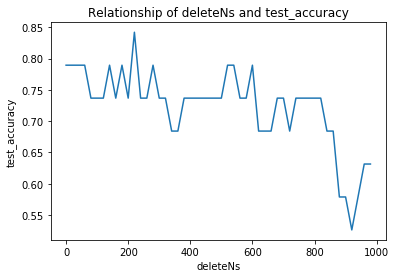

finished


In [30]:
print ("start")

# 文本预处理
folder_path = './Database/SogouC/Sample'

all_words_list, train_data_list, train_class_list, test_data_list, test_class_list = text_processing(folder_path, test_rate=0.2)

# 生成stopwords_set
stopwords_file = './stopwords_cn.txt'
stopwords_set = make_word_set(stopwords_file)

# 文本特征提取和分类
flag = 'sklearn'
deleteNs = range(0, 1000, 20)
test_accuracy_list = []
for deleteN in deleteNs:
    feature_words = vocab_select(all_words_list, deleteN, stopwords_set)
    train_feature_list, test_feature_list = text_features(train_data_list, test_data_list, feature_words, flag)
    test_accuracy = text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag)
    test_accuracy_list.append(test_accuracy)
print(test_accuracy_list)

# 结果评价
plt.figure()
plt.plot(deleteNs, test_accuracy_list)
plt.title('Relationship of deleteNs and test_accuracy')
plt.xlabel('deleteNs')
plt.ylabel('test_accuracy')
plt.show()
#plt.savefig('result.png')

print ("finished")